<a href="https://colab.research.google.com/github/elahe-ghafari/my-final-project/blob/main/vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os                       # for working with files

import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import tensorflow as ts
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
with ZipFile ('/content/drive/My Drive/melanom.zip','r') as zipObj:
  zipObj.extractall('melanom')

In [ ]:
from google.colab import files
!zip -r /content/melanom.zip /content/melanom
files.download('/content/drive/My Drive/melanom.zip')

Streaming output truncated to the last 5000 lines.
updating: content/melanom/melanoma_cancer_dataset/train/malignant/melanoma_8875.jpg (deflated 1%)
updating: content/melanom/melanoma_cancer_dataset/train/malignant/melanoma_7108.jpg (deflated 2%)
updating: content/melanom/melanoma_cancer_dataset/train/malignant/melanoma_8501.jpg (deflated 2%)
updating: content/melanom/melanoma_cancer_dataset/train/malignant/melanoma_9217.jpg (deflated 2%)
updating: content/melanom/melanoma_cancer_dataset/train/malignant/melanoma_5538.jpg (deflated 1%)
updating: content/melanom/melanoma_cancer_dataset/train/malignant/melanoma_7251.jpg (deflated 8%)
updating: content/melanom/melanoma_cancer_dataset/train/malignant/melanoma_9141.jpg (deflated 3%)
updating: content/melanom/melanoma_cancer_dataset/train/malignant/melanoma_5209.jpg (deflated 1%)
updating: content/melanom/melanoma_cancer_dataset/train/malignant/melanoma_8871.jpg (deflated 2%)
updating: content/melanom/melanoma_cancer_dataset/train/malignant/m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_dir = 'melanom/melanoma_cancer_dataset/train'
skin = os.listdir(train_dir)
skin

['benign', 'malignant']

In [ ]:
# Number of images for each diseas
nums_train = {}
nums_val = {}
for s in skin:
    nums_train[s] = len(os.listdir(train_dir + '/' + s))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


,no. of images
benign,5000
malignant,4605


<Axes: title={'center': 'data distribution '}, xlabel='Type of skin cancer', ylabel='Number of image'>

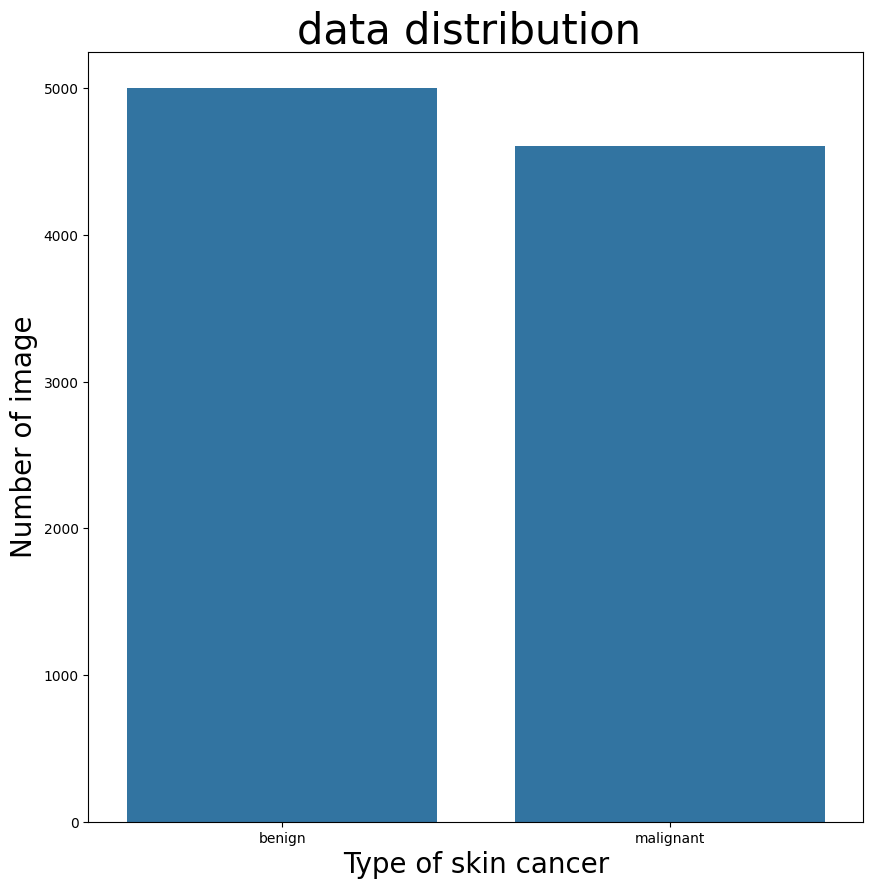

In [ ]:
plt.figure(figsize=(10,10))
plt.title('data distribution ', fontsize=30)
plt.ylabel('Number of image', fontsize=20)
plt.xlabel('Type of skin cancer', fontsize=20)

keys = list(nums_train.keys())
vals = list(nums_train.values())
sns.barplot(x=keys, y=vals)

In [ ]:
# Function to show image
train = ImageFolder(train_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

Modeling

In [ ]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range = 0.30 ,
                                                         horizontal_flip = True ,
                                                         validation_split = 0.2
                                                         )
valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.2)
train_data = train_gen.flow_from_directory(train_dir, subset='training', target_size=(112, 112), batch_size=64, color_mode='rgb',
                                            class_mode='categorical', shuffle=True)

test_data = valid_gen.flow_from_directory(train_dir, subset='validation', target_size=(112, 112), batch_size=64, color_mode='rgb',
                                            class_mode='categorical', shuffle=False)

Found 7684 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.


In [ ]:
X_train = []
y_train = []

# Iterate over the generator to collect all samples and labels
for i in range(len(train_data)):
    batch_X, batch_y = train_data[i]
    X_train.append(batch_X)
    batch_y = np.argmax(batch_y, axis=1)
    y_train.append(batch_y)

# Concatenate the batches into numpy arrays
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = []
y_test = []

# Iterate over the generator to collect all samples and labels
for i in range(len(test_data)):
    batch_X, batch_y = test_data[i]
    X_test.append(batch_X)
    batch_y = np.argmax(batch_y, axis=1)
    y_test.append(batch_y)

# Concatenate the batches into numpy arrays
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, models, callbacks
num_classes = 2
input_shape = (112, 112, 3)
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 64
num_epochs = 20  # For real training, use num_epochs=100. 10 is a test value
image_size = 112  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_vit_classifier():
    inputs = keras.Input(shape=(image_size, image_size, 3))
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    outputs = layers.Dense(1, activation='sigmoid')(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Assuming you have loaded and preprocessed your data into X_train, y_train, X_test, y_test

# Define your ViT model
vit_classifier = create_vit_classifier()

# Compile your model
# optimizer = keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
# vit_classifier.compile(
#     optimizer=optimizer,
#     loss=keras.losses.BinaryCrossentropy(from_logits=False),
#     metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
#              keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")]
# )

# # Run the training experiment
# history = vit_classifier.fit(
#     x=X_train,
#     y=y_train,
#     batch_size=batch_size,
#     epochs=num_epochs,
#     validation_split=0.2
# )

# Evaluate the model
# _, accuracy, top_5_accuracy = vit_classifier.evaluate(X_test, y_test)
# print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

# # Plot training history
#  def plot_history(history):
#      plt.plot(history.history["loss"], label="loss")
#      plt.plot(history.history["val_loss"], label="val_loss")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.title("Train and Validation Loss Over Epochs")
#     plt.legend()
#     plt.grid()
#     plt.show()

# plot_history(history)


In [ ]:
# Load and preprocess the data
# Assuming X_train, y_train, X_test, y_test are loaded and preprocessed

# Define and compile the model
vit_classifier = create_vit_classifier()

# Compile the model with appropriate loss and metrics
vit_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.AUC(name="auc"),
    ],
)

# Train the model
history = vit_classifier.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.2,
    class_weight={0: 1, 1: 1},  # Adjust class weights if necessary
)

# Evaluate the model
evaluation = vit_classifier.evaluate(X_test, y_test)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])
print("Test Precision:", evaluation[2])
print("Test Recall:", evaluation[3])
print("Test AUC:", evaluation[4])

# Plot training history
plot_history(history)


In [ ]:
pip install vit-keras

In [ ]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


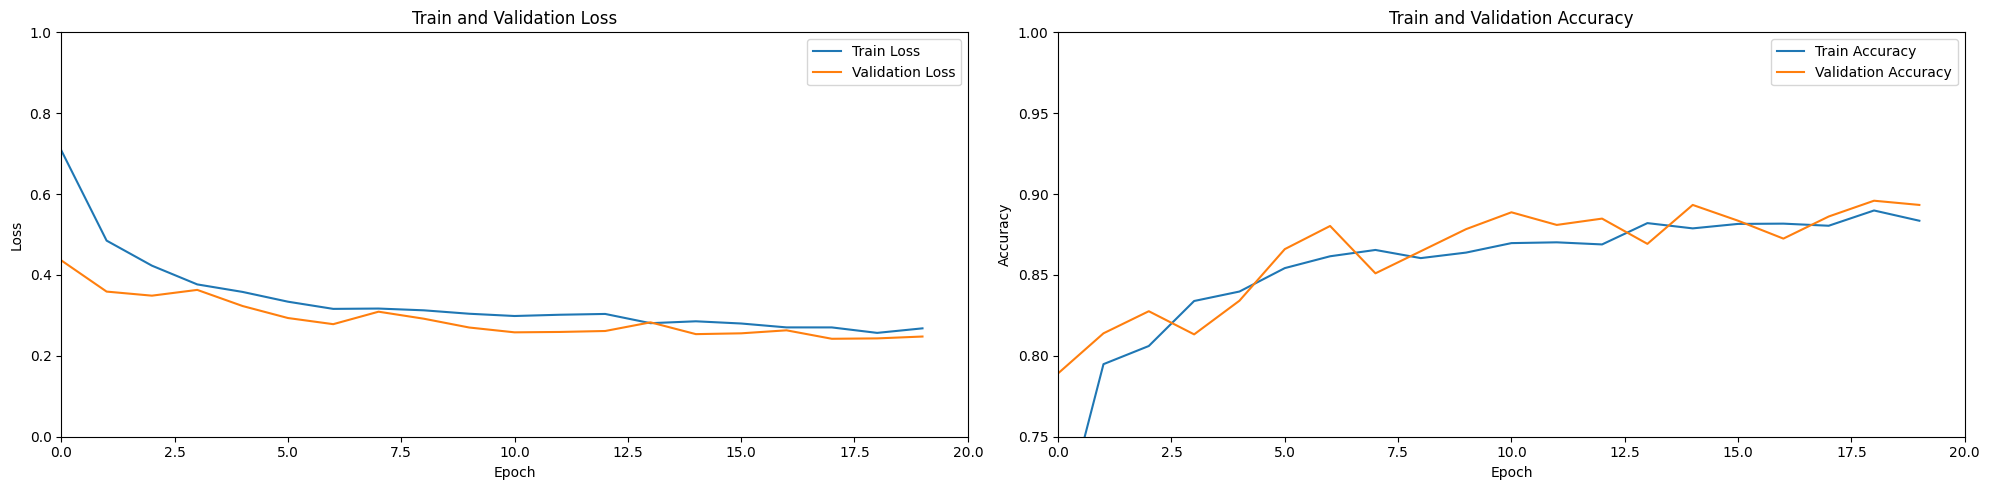

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, len(history.history['loss']))  # Adjust x-axis limit based on number of epochs
plt.ylim(0.0, 1.0)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, len(history.history['accuracy']))  # Adjust x-axis limit based on number of epochs
plt.ylim(0.75, 1.0)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Generate predictions using your cnn-ViT model
Y_pred = hybrid_model.predict(X_test)
y_pred = (Y_pred > 0.5).astype(int)  # Assuming binary classification and using a threshold of 0.5

# Print classification report
print(classification_report(y_test, y_pred))


NameError: name 'hybrid_model' is not defined

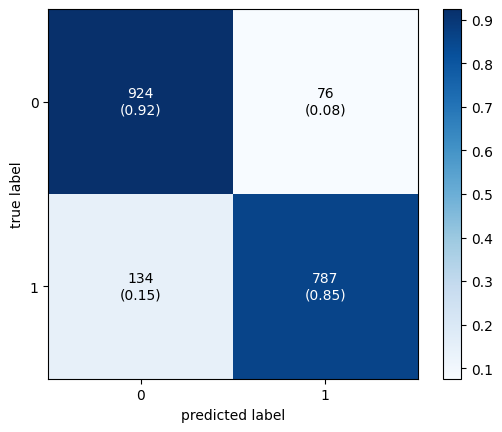

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Assuming you have predictions (y_pred) from your model

# Convert probabilities to class labels
y_pred_labels = (y_pred > 0.5).astype(int)  # Assuming binary classification and using a threshold of 0.5

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plot_confusion_matrix(conf_mat=cm,
                      show_absolute=True,  # Show absolute counts
                      show_normed=True,    # Show normalized counts
                      colorbar=True)
plt.show()
